In [34]:
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, getopt
import argparse
from decimal import *


In [35]:
isa='arm'
vlen='128'
target = isa + '+' + vlen
spec = 'int'

In [36]:
data = []
fields = ['A','Float','RV32A','RV32C','RV32D','RV32F','RV32I','RV32M','RV64A','RV64I','RV64M','RV64V','Zicsr','nclas','sum'] if 'riscv' in target  else (
            'A', 'SVE', 
            'PCrel addr', 'Add/Sub (imm,tags)', 'Add/Sub (imm)', 'Logical (imm)', 'Move Wide (imm)', 'Bitfield', 'Extract', 'Data Proc Imm',
            'Cond Branch (imm)', 'Exception Gen', 'NOP', 'Hints', 'Barriers', 'System Insn',  'System Reg',  'Branch (reg)', 'Branch (imm)',  'Cmp & Branch', 'Tst & Branch', 'Branches', 
            'AdvSimd ldstmult', 'AdvSimd ldstmult++', 'AdvSimd ldst', 'AdvSimd ldst++', 'ldst excl',  'Prefetch', 'Load Reg (lit)', 'ldst noalloc pair', 'ldst pair', 'ldst reg', 'Atomic ldst', 'ldst reg (reg off)', 'ldst reg (pac)', 'ldst reg (imm)', 'Loads & Stores', 
            'Data Proc Reg',  
            'AdvSimd Scalar', 'AdvSimd other', 'Scalar FP', 'sum')

riscv_class = {
            'A': [], 'sum': [], 
            
}

arm_class = {
            'A': [], 'sum': [],  
            'SVE': ['SVE'], 
            'Data Processing Immediate': ['PCrel addr', 'Add/Sub (imm,tags)', 'Add/Sub (imm)', 'Logical (imm)', 'Move Wide (imm)', 'Bitfield', 'Extract', 'Data Proc Imm'], 
            'Branches': ['Cond Branch (imm)', 'Exception Gen', 'NOP', 'Hints', 'Barriers', 'System Insn',  'System Reg',  'Branch (reg)', 'Branch (imm)',  'Cmp & Branch', 'Tst & Branch', 'Branches'], 
            'Loads and Stores': ['ldst excl',  'Prefetch', 'Load Reg (lit)', 'ldst noalloc pair', 'ldst pair', 'ldst reg', 'Atomic ldst', 'ldst reg (reg off)', 'ldst reg (pac)', 'ldst reg (imm)', 'Loads & Stores'], 
            'Data Processing Register': ['Data Proc Reg'], 
            'Scalar FP': ['Scalar FP'], 
            'Neon': ['AdvSimd ldstmult', 'AdvSimd ldstmult++', 'AdvSimd ldst', 'AdvSimd ldst++','AdvSimd Scalar', 'AdvSimd other']
          }


dir = "/home/jerry/Speckle/"
BENCHMARKS=["bzip2", "gcc",  "mcf", "gobmk" , "hmmer" , "sjeng"  ,"libquantum", "h264ref", "omnetpp" ,"astar", "Xalan"] if spec == 'int' else ["dealII", 'lbm', 'milc', 'namd', 'povray', 'soplex', 'sphinx']
# BENCHMARKS=['h264ref']


In [37]:
def prune(string: str):
    i = 0
    j = len(string) - 1

    while ('a' > string[i] or string[i] > 'z') and ('A' > string[i] or string[i] > 'Z') and string[i] != ')':
        i += 1
    
    while ('a' > string[j] or string[j] > 'z') and ('A' > string[j] or string[j] > 'Z') and string[j] != ')':
        j -= 1

    # print(string[i:j+1])
    
    return string[i:j+1]


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Spectral'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    # ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts.max(), height=0.5,
                        label=colname, color=color, align='center')

        r, g, b, _ = color
        text_color = 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

[{'A': 'O3_Nslp_Nloop', 'Branches': 0.181, 'Data Processing Immediate': 0.229, 'Data Processing Register': 0.103, 'Loads and Stores': 0.488, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3_Nslp', 'Branches': 0.181, 'Data Processing Immediate': 0.229, 'Data Processing Register': 0.103, 'Loads and Stores': 0.488, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3', 'Branches': 0.181, 'Data Processing Immediate': 0.229, 'Data Processing Register': 0.103, 'Loads and Stores': 0.488, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3_Nloop', 'Branches': 0.181, 'Data Processing Immediate': 0.229, 'Data Processing Register': 0.103, 'Loads and Stores': 0.488, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}]
{'O3': [0.181, 0.229, 0.103, 0.488, 0.0, 0.0, 0.0], 'O3_Nloop': [0.181, 0.229, 0.103, 0.488, 0.0, 0.0, 0.0], 'O3_Nslp': [0.181, 0.229, 0.103, 0.488, 0.0, 0.0, 0.0], 'O3_Nslp_Nloop': [0.181, 0.229, 0.103, 0.488, 0.0, 0.0, 0.0]}
[{'A': 'O3

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[{'A': 'O3_Nslp_Nloop', 'Branches': 0.232, 'Data Processing Immediate': 0.135, 'Data Processing Register': 0.139, 'Loads and Stores': 0.493, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3_Nslp', 'Branches': 0.232, 'Data Processing Immediate': 0.135, 'Data Processing Register': 0.139, 'Loads and Stores': 0.493, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3', 'Branches': 0.232, 'Data Processing Immediate': 0.135, 'Data Processing Register': 0.139, 'Loads and Stores': 0.493, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}, {'A': 'O3_Nloop', 'Branches': 0.232, 'Data Processing Immediate': 0.135, 'Data Processing Register': 0.139, 'Loads and Stores': 0.493, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.0, 'sum': 1.0}]
{'O3': [0.232, 0.135, 0.139, 0.493, 0.0, 0.0, 0.0], 'O3_Nloop': [0.232, 0.135, 0.139, 0.493, 0.0, 0.0, 0.0], 'O3_Nslp': [0.232, 0.135, 0.139, 0.493, 0.0, 0.0, 0.0], 'O3_Nslp_Nloop': [0.232, 0.135, 0.139, 0.493, 0.0, 0.0, 0.0]}
[{'A': 'O3

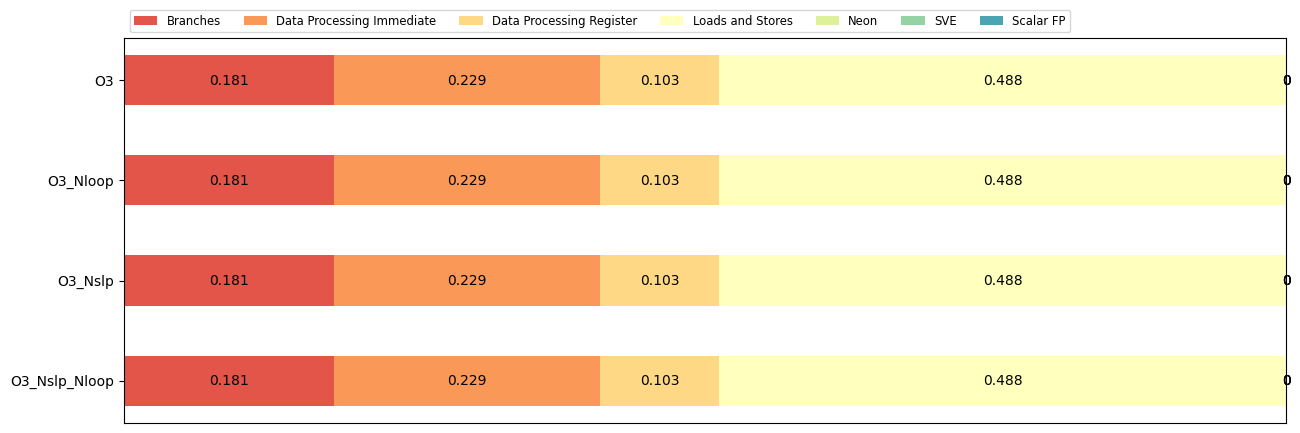

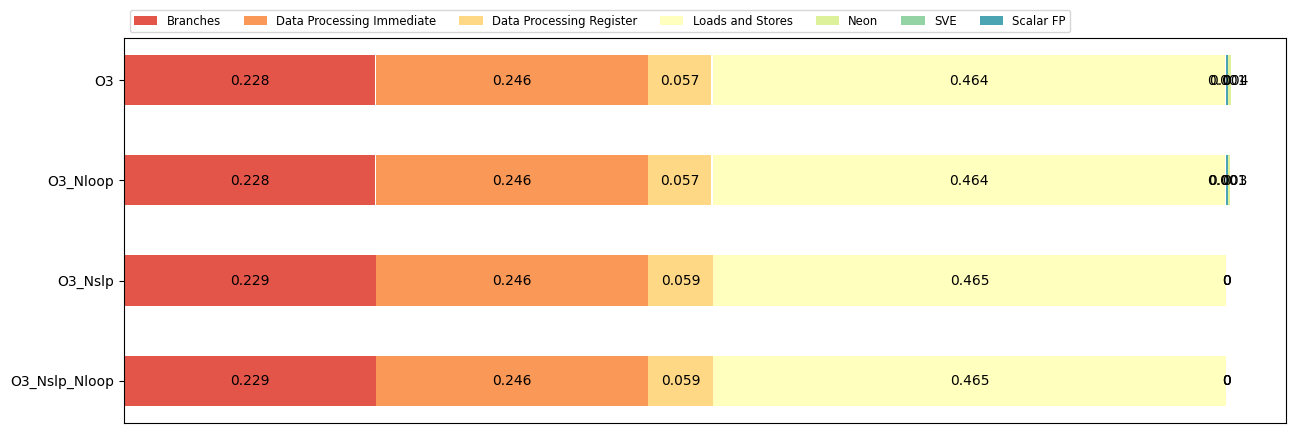

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


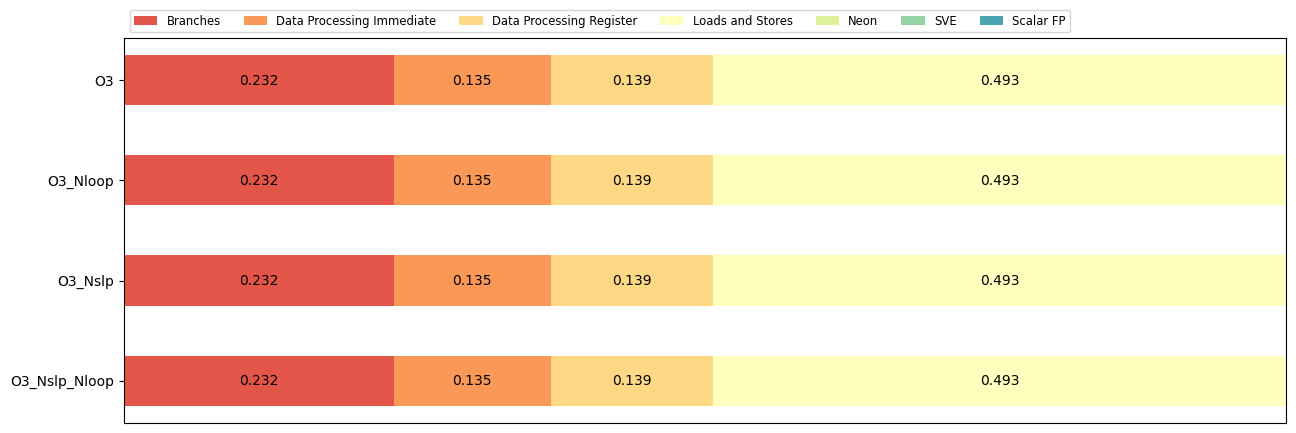

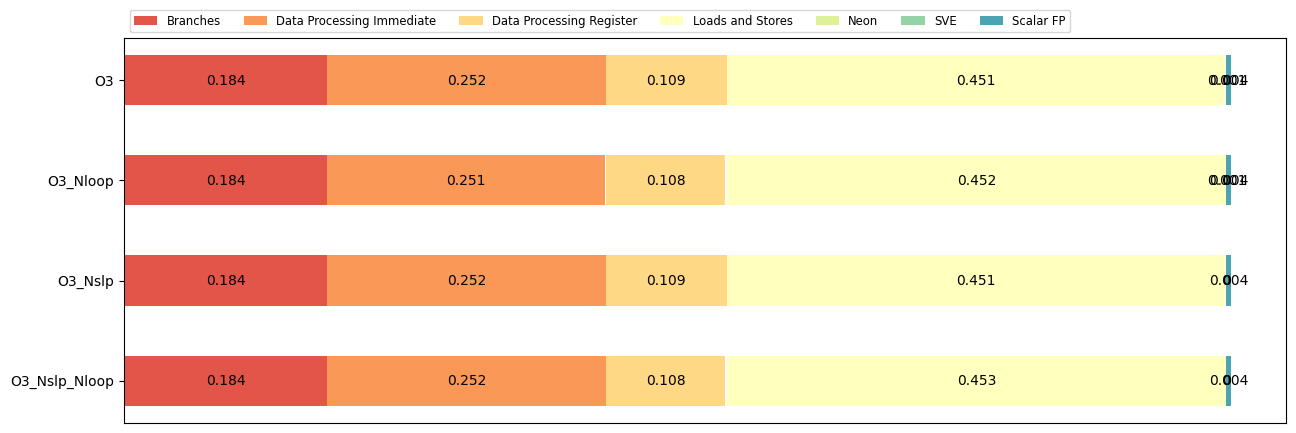

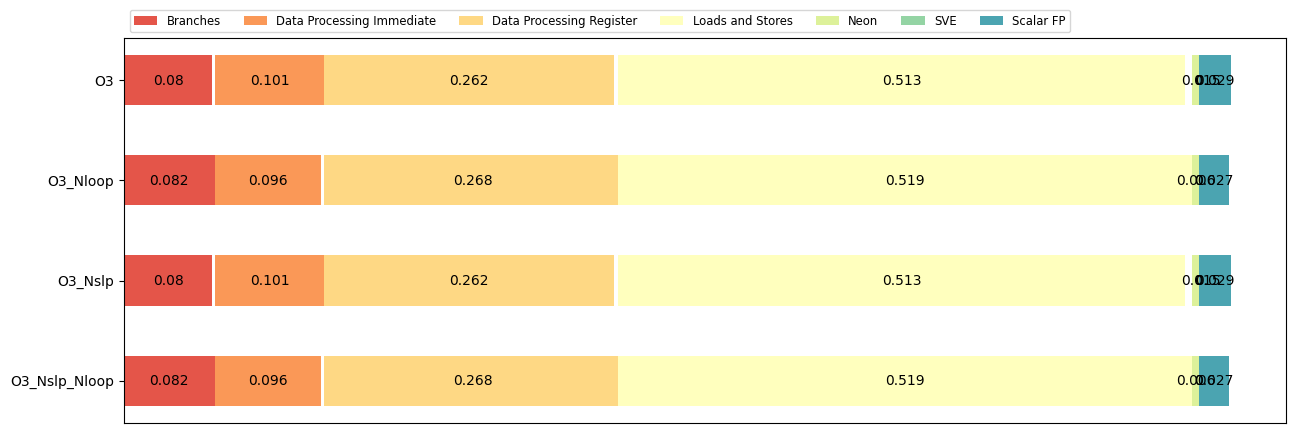

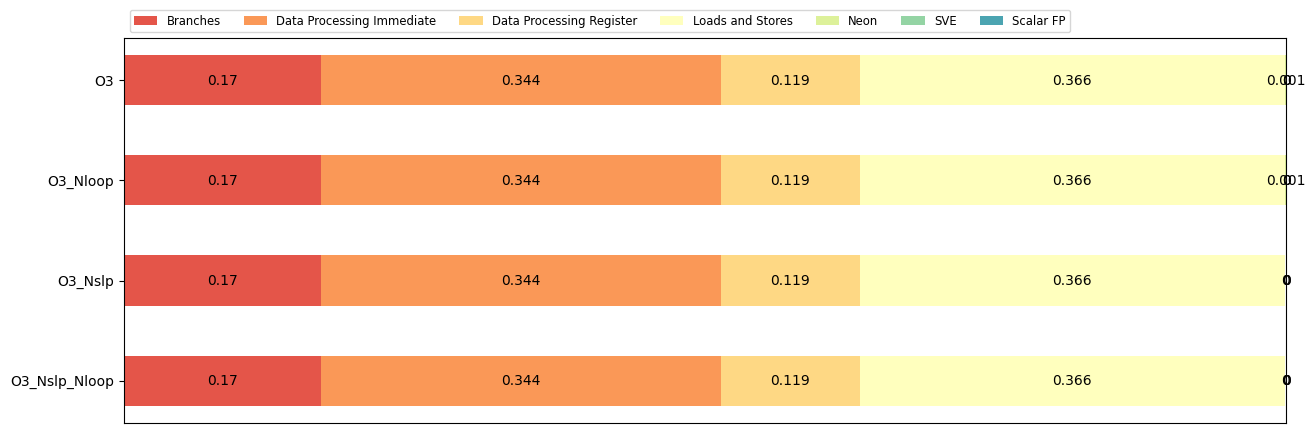

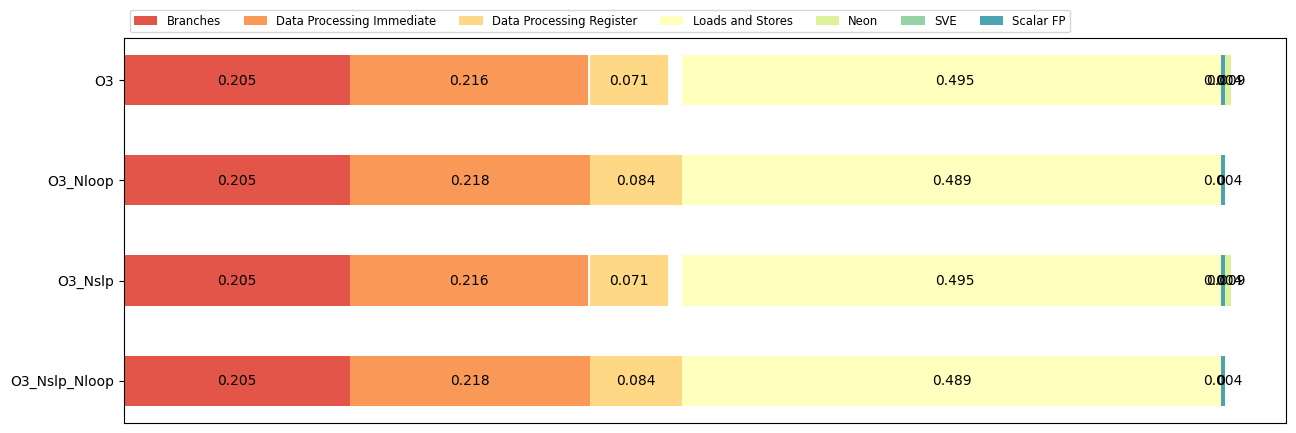

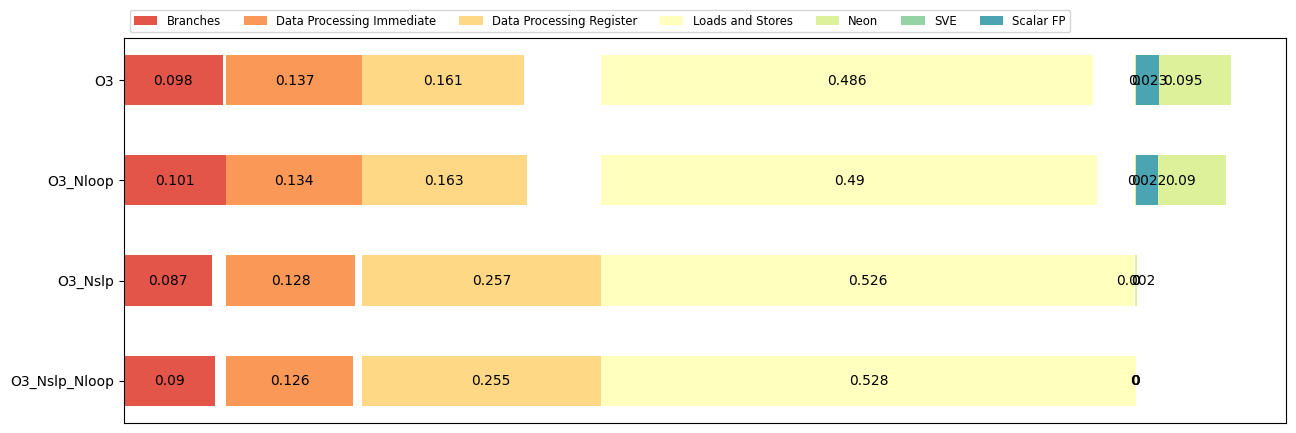

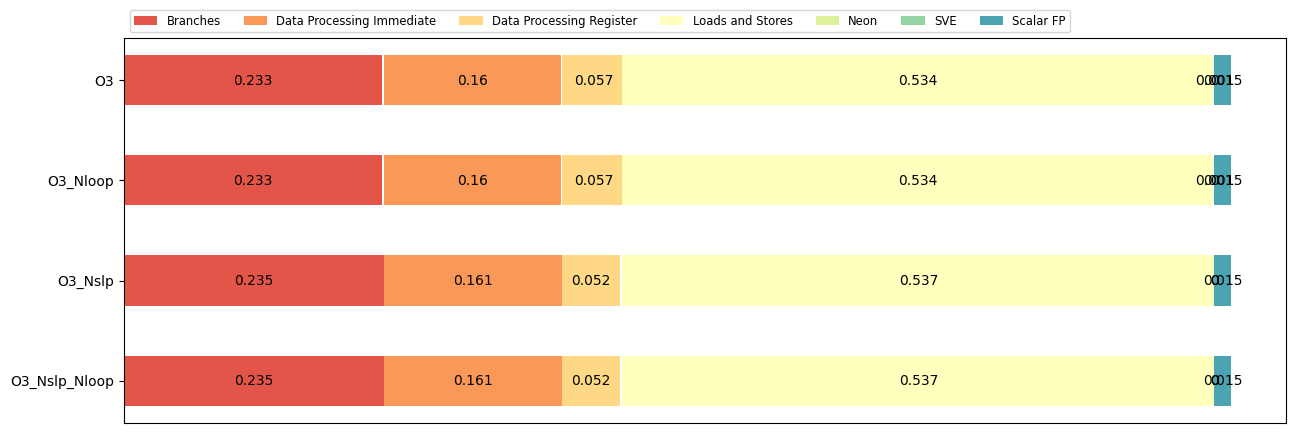

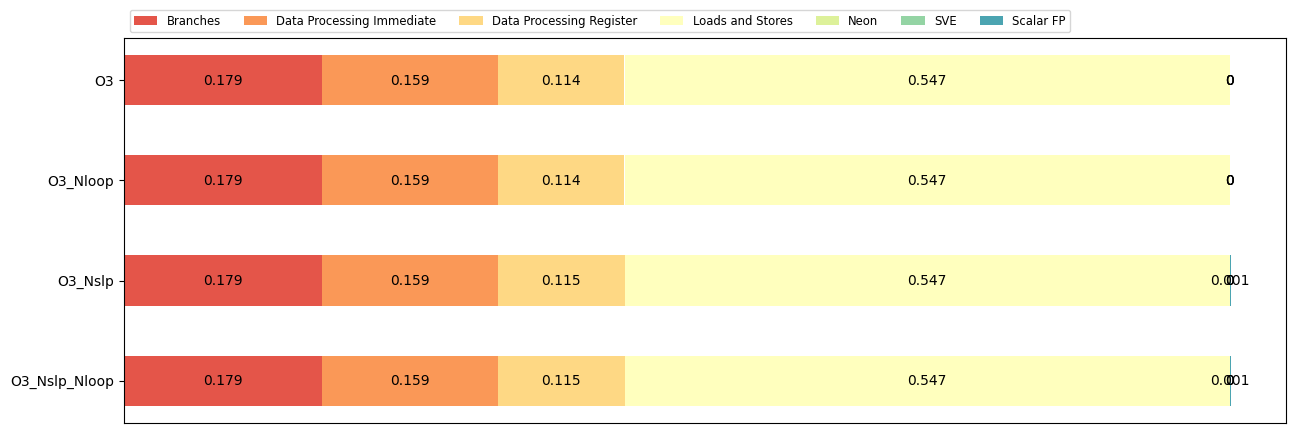

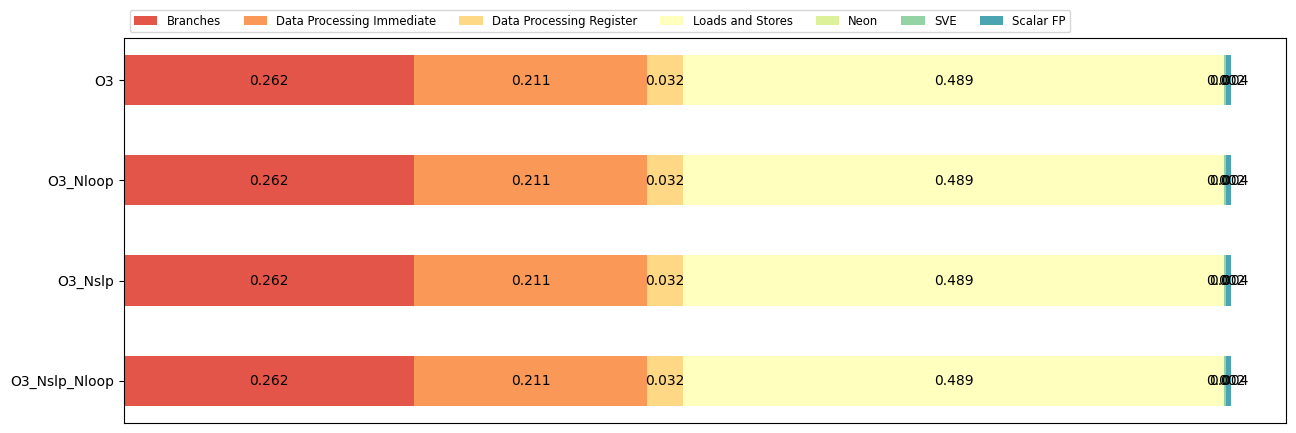

In [38]:
for benchmark in BENCHMARKS:
    for file in glob.iglob('result/' + target + '_' + spec + '*/*.out', recursive=True):

        # print("Processing {} ...".format(file))

        if file.find(benchmark) == -1:
            # print("Skipping")
            continue
        
        fp = open(dir + file, 'r')
        lines = fp.readlines()    

        m = dict()
        sum = 0

        for line in lines:
            if line[0:5] != 'Class':
                continue

            line = line.split('\t')
            num = line[1].split(' ')[0][1:]

            if '0' > num[0] or num[0] > '9':
                continue

            count = int(num)
            category = line[0][13:18] if 'riscv' in target  else prune(line[0][6:])

            if 'arm' in target:
                for key in arm_class.keys():
                    if category in arm_class[key]:
                        category = key
                        break

            if category not in m.keys():
                m.setdefault(category, 0)
            
            m[category] += count
            sum += count
        
        for key in m.keys():
            m[key] = round(m[key] / sum, 3)

        
        m.setdefault("sum", sum)
        m.setdefault("A", '_'.join(file.split('/')[1].split('_')[2:]))
        
        data.append(dict(sorted(m.items())))


    # data.insert(0, data.pop())
    # data.insert(0, data.pop())
    # print(file)
    # print(benchmark)
    # print(data)
    # print(m)

    for i in range(0, len(data)):
        if 'O3_Nslp_Nloop' in data[i].values():
            std = data[i]['sum']

    for i in range(0, len(data)):
        data[i]['sum'] = round(data[i]['sum'] / std, 3)
    
    # data[0]['sum'] = 1
    print(data)

    result = {data[i]['A']: [val for val in data[i].values()][1:-1] for i in range(len(data))}
    result = dict(sorted(result.items()))
    
    print(result)

    survey(results=result, category_names=[i for i in data[0].keys()][1:-1])
    plt.savefig("./fig/" + target + '_' + benchmark + ".png")

    if not os.path.exists(dir + "stat/" + target):
        os.mkdir(dir + "stat/" + target)

    with open(dir + "stat/" + target + "/" + benchmark + "_output.csv", "w+", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields if 'riscv' in target else arm_class.keys())
        
        writer.writeheader()
        
        for row in data:
            writer.writerow(row)
    
    data.clear()


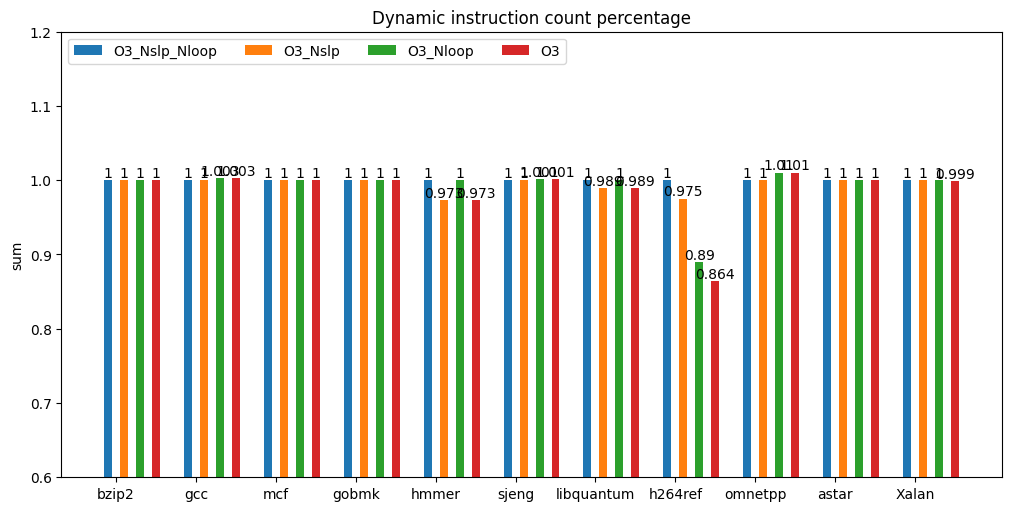

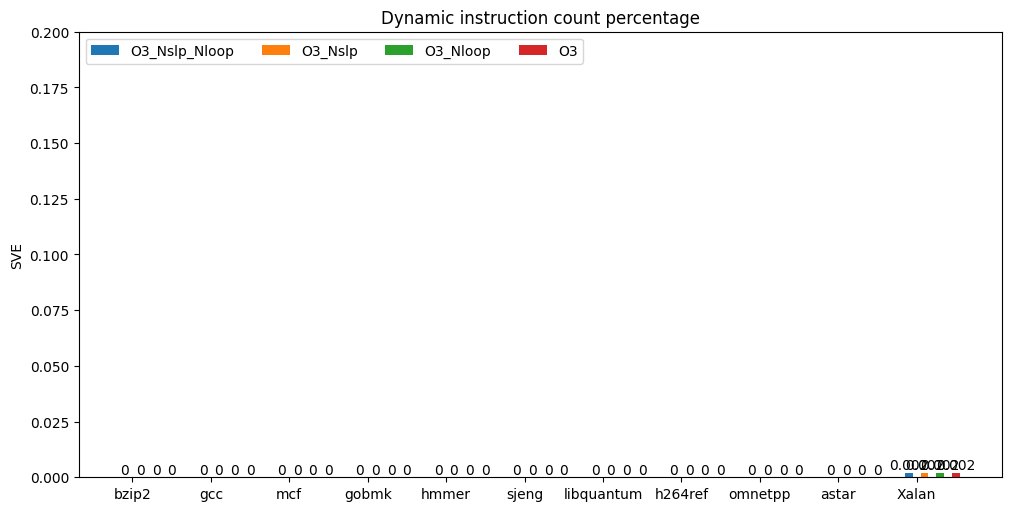

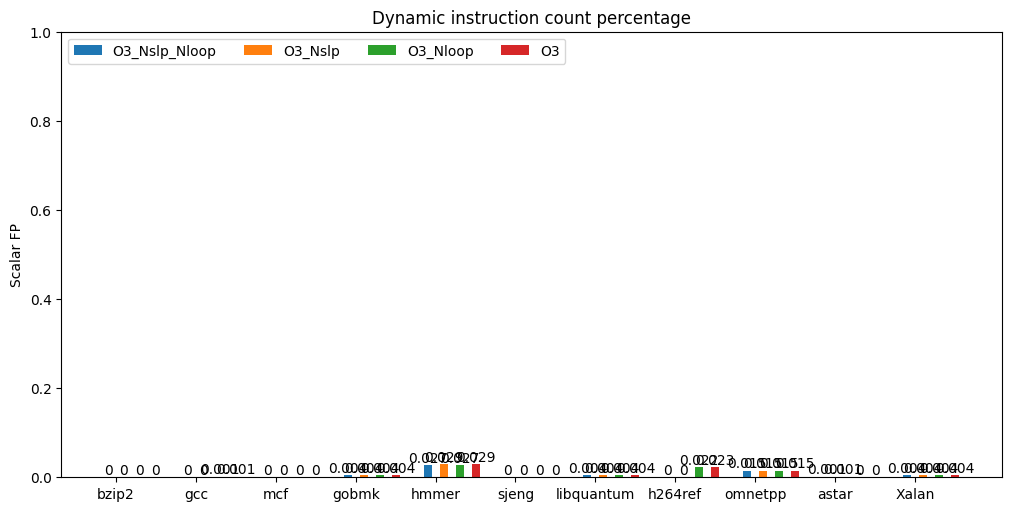

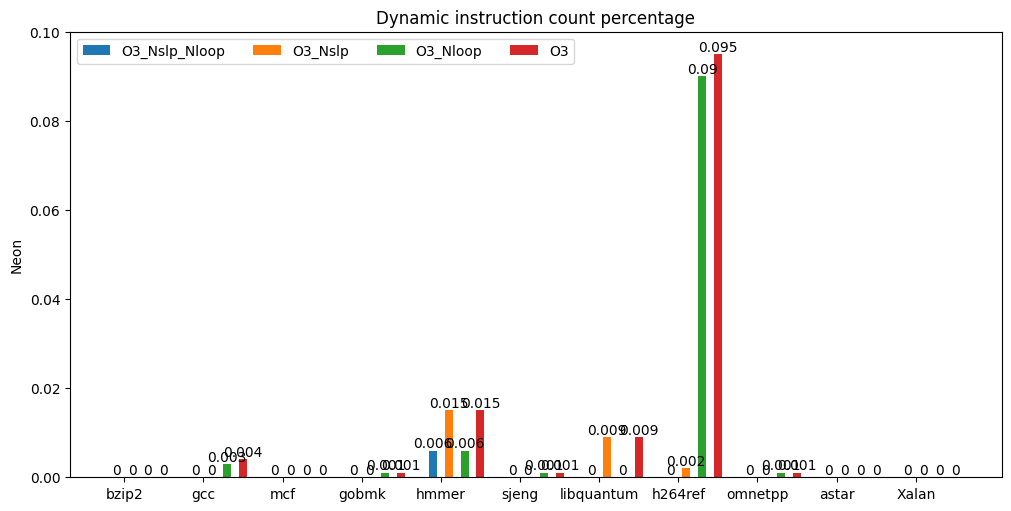

In [41]:
df = pd.DataFrame()
cnt = 0

for benchmark in BENCHMARKS:
    for file in glob.iglob('stat/' + target + '/*', recursive=True):
        if file.find(benchmark) == -1:
            continue
        
        cur = pd.read_csv(file)
        cur.index = [benchmark] * len(cur.axes[0])
        cur = cur.sort_values(by=['A'], ascending=False)
        # cur.drop('sum', axis=1).plot.barh(x='A', stacked=True)
        # plt.savefig('tmp.png')
        df = pd.concat([df, cur])
        # print([benchmark * len(df.axes[0])])
        # df.index = [benchmark] * len(df.axes[0])
    

df.to_csv('./output/{}_{}.csv'.format(target, spec))

def generate_result(field, range=(0.6, 1.2)):
    tmp = {'O3_Nslp_Nloop': df.loc[df['A'] == 'O3_Nslp_Nloop'][field].to_list(), 
        'O3_Nslp': df.loc[df['A'] == 'O3_Nslp'][field].to_list(), 
        'O3_Nloop': df.loc[df['A'] == 'O3_Nloop'][field].to_list(), 
        'O3': df.loc[df['A'] == 'O3'][field].to_list()}

    # print(tmp)
    x = np.arange(len(BENCHMARKS))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(10, 5)

    for attribute, measurement in tmp.items():
        # print(attribute, measurement)
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects)
        multiplier += 2

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(field)
    ax.set_title('Dynamic instruction count percentage')
    ax.set_xticks(x + width, BENCHMARKS)
    ax.legend(loc='upper left', ncols=len(BENCHMARKS))
    ax.set_ylim(range)
    plt.savefig('./fig/{}_{}_{}.png'.format(target, spec, field))

generate_result('sum')

if 'riscv' in target :
    generate_result('RV64V', (0, 0.1))
    # generate_result('Float', (0, 1))
else:
    generate_result('SVE', (0, 0.2))
    generate_result('Scalar FP', (0, 1))
    generate_result('Neon', (0, 0.1))


In [2]:
import subprocess

target = 'arm'

with open("/home/jerry/Speckle/result/{}+128_464.h264ref_O3/h264ref_base.{}.out".format(target, target), 'r') as fp \
    , open('{}.addr2line.log'.format(target), 'a') as addrfile \
    , open('{}.objdump.log'.format(target), 'a') as objfile \
    , open('{}.disassem.log'.format(target), 'a')as disfile:

    addrfile.truncate(0)
    objfile.truncate(0)
    disfile.truncate(0)

    subprocess.call(['/home/jerry/llvm-project/{}/bin/llvm-objdump'.format(target), '-d',
                    '/home/jerry/spec2006/SPEC_CPU2006v1.1.cp/benchspec/CPU2006/464.h264ref/exe/h264ref_base.{}'.format(target)], 
                    stdout=objfile, shell=False)

    lines = fp.readlines()
    for line in lines:
        line = line.split(', ')
        pc = line[0]
        insns = line[2]
        count = line[3]
        subprocess.call(['/home/jerry/llvm-project/arm/bin/llvm-addr2line',  
                        '-Cfi', 
                        '-e', '/home/jerry/spec2006/SPEC_CPU2006v1.1.cp/benchspec/CPU2006/464.h264ref/exe/h264ref_base.{}'.format(target), pc], 
                        stdout=addrfile, 
                        shell=False)

        
        subprocess.call(['grep', str(hex(int(pc[2:], 16)))[2:] + ':', '{}.objdump.log'.format(target), '-A{}'.format(int(insns) - 1)], 
                        stdout=disfile, 
                        shell=False)
        


In [3]:
with open("/home/jerry/Speckle/result/{}+128_464.h264ref_O3_Nslp/h264ref_base.{}.out".format(target, target), 'r') as fp, \
    open('{}.addr2line.log'.format(target), 'r') as addrfile, \
    open('{}.disassem.log'.format(target), 'r') as disfile, \
    open('{}.log'.format(target), 'a') as logfile:

    infolines = fp.readlines()
    addrlines = addrfile.readlines()
    dislines = disfile.readlines()
    logfile.truncate(0)

    i, j = 0, 0
    
    for line in infolines:
        line = line.split(', ')
        pc = line[0]
        insns = line[2]
        count = line[3]

        # print(''.join(addrlines[i:i+2]))
        # print(''.join(dislines[j:j+int(insns)]))

        logfile.write(''.join(addrlines[i:i+2]))
        logfile.write(''.join(dislines[j:j+int(insns)]))

        i += 2
        j += int(insns)
